# Instructions

First make sure you followed the steps sent per email:

_To make the most of the workshop you should bring your laptop with Anaconda installed (see [anaconda](https://www.anaconda.com/products/distribution%3E) for how to install). Once conda is installed you can already download MNE python (https://mne.tools/) to save some time during the set-up, a recommended way is to use a dedicated conda environment as follows (see [conda managing environments](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#)):_
```
$ conda create --override-channels --channel=conda-forge --name=hmp mne
```

Then activate the created environment through the terminal (linux/MacOS) or through the Anaconda Prompt (windows):
```
conda activate hmp
pip install hsmm_mvpy
```

If everything went without error you can download the tutorials folder on the associated github page https://github.com/GWeindel/hsmm_mvpy/tree/main/tutorials
If you had troubles during the installation contact us.

Navigate to the folder where you downloaded the repository through the terminal/prompt and launch open a jupyter notebook session (alternatively you can also first launch the following command and then navigate to the folder):

```
jupyter notebook
```

You should see the content of the folder you downloaded, during the workshop we will be using the notebooks in the folder /workshop.
After this execute these cells up to data format and wait for the workshop to resume

# Practical, methodological and theoretical grounds

## Data 

### Simulation

In [1]:
## Importing these packages is specific for this simulation case
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma

## Importing HMP
import hsmm_mvpy as hmp
from hsmm_mvpy import simulations

In [2]:
cpus = 2 # For multiprocessing, usually a good idea to use multiple CPUs as long as you have enough RAM

n_trials = 100 #Number of trials to simulate
sfreq = 500
##### Here we define the sources of the brain activity (event) for each trial
n_events = 4
n_stages = n_events+1
frequency = 10.#Frequency of the event defining its duration, half-sine of 10Hz = 50ms
amplitude = .2e-6 #Amplitude of the event in nAm, defining signal to noise ratio
shape = 2 #shape of the gamma distribution
means = np.array([60, 150, 200, 100, 80])/shape #Mean duration of the stages in ms
names = simulations.available_sources()[:n_stages+1]#Which source to activate at each stage (see atlas when calling simulations.available_sources())

sources = []
for source in zip(names, means):#One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

# Function used to generate the data
file = simulations.simulate(sources, n_trials, cpus, 'dataset_raw', overwrite=False, sfreq=sfreq, seed=1234)
#load electrode position, specific to the simulations
positions = simulations.simulation_positions()


/home/gweindel/owncloud/projects/RUGUU/main_hmp/hsmm_mvpy/src/hsmm_mvpy/simulations.py:165: UserWarning: ./dataset_raw_raw.fif exists no new simulation performed
  warn(f'{subj_file} exists no new simulation performed', UserWarning)


The goal of this cell is to have a realistic EEG dataset for a single participant

In [3]:
#Recovering the events to epoch the data (in the number of trials defined above)
events = np.load(file[1])
resp_trigger = int(np.max(np.unique(events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}
#Keeping only stimulus and response triggers

#Visualising the raw simulated EEG data
import mne
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events, block=True);

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using qt as 2D backend.
Channels marked as bad:
none


### Data Format 
Now we read the data into an xarray.

In [4]:
# Reading the data
eeg_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, sfreq=sfreq, 
            events_provided=events, verbose=False)
eeg_data

Processing participant ./dataset_raw_raw.fif's continuous eeg
Reading 0 ... 365990  =      0.000 ...   731.980 secs...
100 trials were retained for participant ./dataset_raw_raw.fif


<xarray.Dataset>
Dimensions:      (participant: 1, epochs: 100, channels: 59, samples: 663)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * channels     (channels) <U7 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 656 657 658 659 660 661 662
    event_name   (epochs) object 'stimulus' 'stimulus' ... 'stimulus' 'stimulus'
    rt           (epochs) float64 1.326 0.264 0.464 0.74 ... 0.48 0.496 0.914
  * participant  (participant) <U2 'S0'
Data variables:
    data         (participant, epochs, channels, samples) float64 -3.232e-06 ...
Attributes:
    sfreq:    500.0
    offset:   0

The previous function epochs the data, cut the EEG data at each RT value and stores any additional infomation along (here 'event_name').

Xarray is a handy way of using matrices but with named dimension. Here for example we can very easily draw an ERP


<xarray.Dataset>
Dimensions:      (participant: 1, epochs: 100, channels: 59, samples: 663)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98 99
  * channels     (channels) <U7 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 656 657 658 659 660 661 662
    event_name   (epochs) object 'stimulus' 'stimulus' ... 'stimulus' 'stimulus'
    rt           (epochs) float64 1.326 0.264 0.464 0.74 ... 0.48 0.496 0.914
  * participant  (participant) <U2 'S0'
Data variables:
    data         (participant, epochs, channels, samples) float64 -3.232e-06 ...
Attributes:
    sfreq:    500.0
    offset:   0


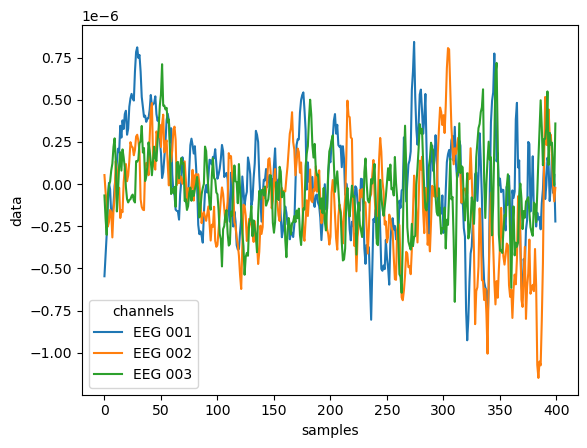

In [5]:
#example of usage of xarray
print(eeg_data)
eeg_data.sel(channels=['EEG 001','EEG 002','EEG 003'], samples=range(400))\
    .data.groupby('samples').mean(['participant','epochs']).plot.line(hue='channels');

Transformation of the data:
- Standardise the individual variances
- Apply PCA
- Zscore the data

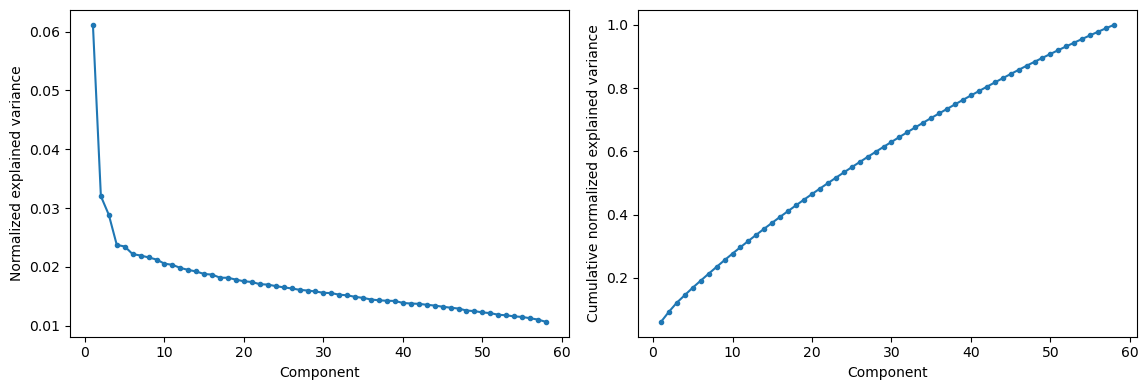

How many PCs (90 and 99% explained variance at component n50 and n58)? 4


In [6]:
hmp_data = hmp.utils.transform_data(eeg_data, apply_standard=False)

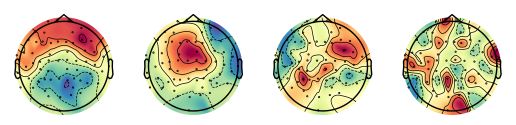

In [7]:
hmp.visu.plot_components_sensor(hmp_data, positions)

## HMP and implementation assumptions

As in Anderson, Zhang, Borst & Walsh, 2016

In [8]:
init = hmp.models.hmp(data=hmp_data, epoch_data=eeg_data, sfreq=eeg_data.sfreq,
                      event_width=50, distribution='gamma', shape=2)

Template of a 50 ms bump (i.e. a 10Hz half-sin)

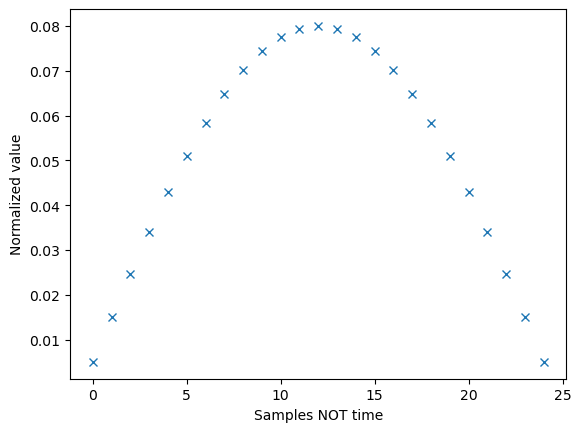

In [9]:
plt.plot(init.template, 'x')
plt.ylabel('Normalized value')
plt.xlabel('Samples NOT time');

When calling ```hmp.models.hmp```, the function automatically cross-correlates the data with the provided template

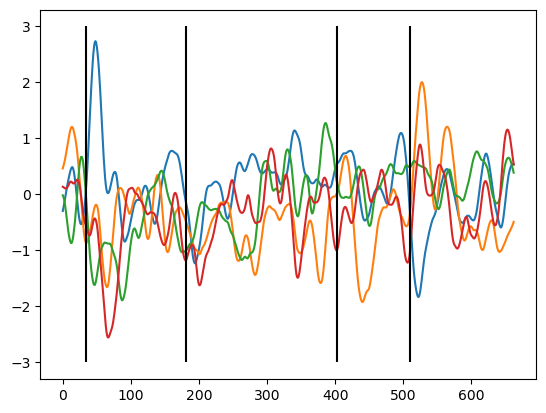

In [10]:
plt.plot(init.data_matrix[:,0,:]);

#Recover the actual time of the simulated events
sim_source_times = np.reshape(np.ediff1d(events[:,0],to_begin=0)[events[:,2] > 1], \
           (n_trials, n_events+1))
plt.vlines(sim_source_times[0,:-1].cumsum()-1, -3, 3, 'k');#overlaying the simulated stage transition times

### HMP parameters

First we recover the actual generating parameters from the simulation

In [11]:
true_pars, true_magnitudes = simulations.recover_true_parameters(init, sim_source_times)

Together these two set of parameters allow us to fit an HMP

Estimating 4 events model
parameters estimated for 4 events model


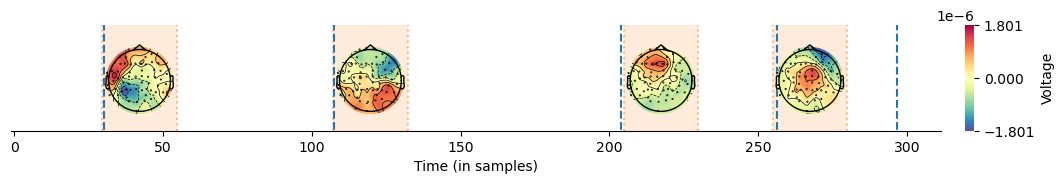

In [12]:
estimates = init.fit_single(n_events, parameters = true_pars, magnitudes=true_magnitudes,
                            maximization=False)

hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, magnify=1, sensors=True, 
        times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

The first element of the set is the expected distribution for stage duration

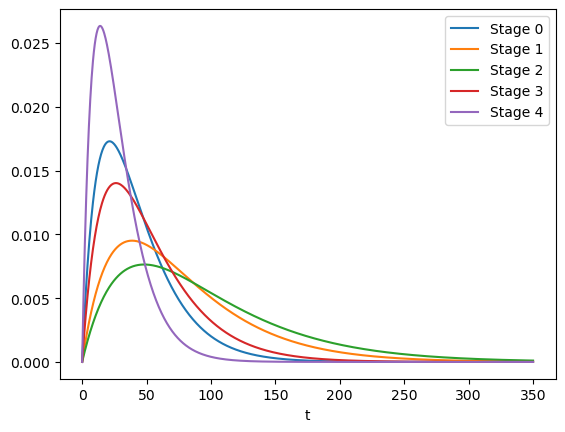

In [13]:
colors = sns.color_palette(None, n_stages)

T = 350
for stage in range(5):
    plt.plot(np.linspace(0,T,1001),gamma.pdf(np.linspace(0,T,1001), 2, scale=true_pars[stage,1]), label=f'Stage {stage}', color=colors[stage]) 
plt.xlabel('t')
plt.legend()

The second element is the contribution of the different electrodes/magnometers/PCs to each of the event

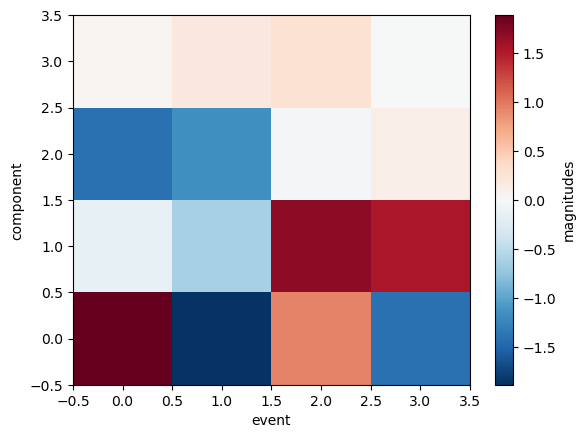

In [14]:
estimates.magnitudes.dropna('event').T.plot()

To estimate this set of parameters (magnitudes and gamma scales) we use the expectation maximization algorithm on the event probability as obtained through the Baum-Welsh algorithm.

Estimating 4 events model with 1 starting point(s)
parameters estimated for 4 events model


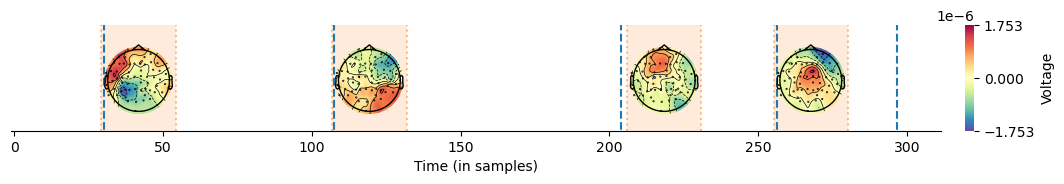

In [15]:
estimates = init.fit_single(n_events, tolerance=1e-8)

hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, magnify=1, sensors=True, 
        times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

We can inspect the traces of the EM algorithm

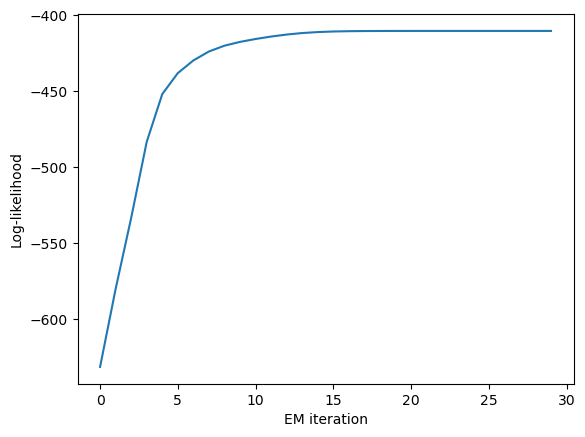

In [16]:
plt.plot(estimates.traces)
plt.ylabel('Log-likelihood')
plt.xlabel('EM iteration');


And check how well our model recovered the original values for the electrode contribution and the time distributions

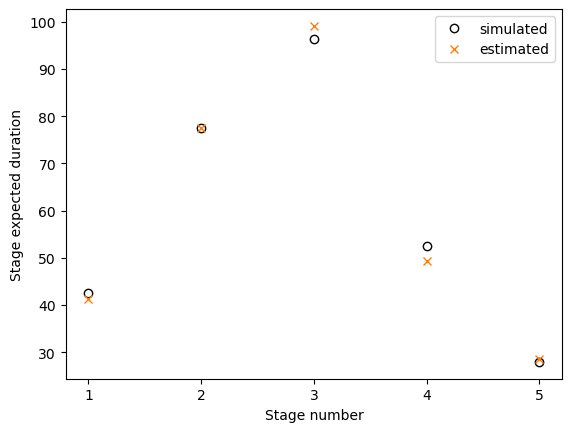

In [17]:
plt.plot(true_pars.prod(axis=1), 'o', label='simulated',mec='k', mfc='w', )
plt.plot(estimates.parameters.prod(axis=1), 'x', label='estimated')#prod() is for a gamma only
plt.xticks(range(5),[1,2,3,4,5])
plt.legend()
plt.xlabel('Stage number')
plt.ylabel('Stage expected duration');

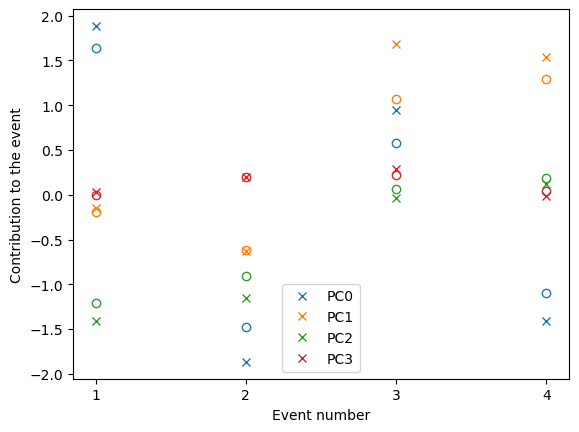

In [18]:
for pc in range(init.n_dims):
    plt.plot(estimates.magnitudes.sel(component=pc), 'o', mec=colors[pc], mfc='w')
    plt.plot(true_magnitudes[:,pc], 'x', label=f'PC{pc}', color=colors[pc])
plt.xticks(range(4),[1,2,3,4])
plt.xlabel('Event number')
plt.ylabel('Contribution to the event')
plt.legend()

## Exploiting model estimates

But in the end what we are really interested in is the event probabilities:

In [19]:
estimates.eventprobs

<xarray.DataArray 'eventprobs' (trial_x_participant: 100, samples: 663, event: 4)>
array([[[0.00000000e+00, 0.00000000e+00, 3.76652484e-25, 0.00000000e+00],
        [1.12362758e-05, 0.00000000e+00, 4.22676272e-25, 1.40385696e-34],
        [2.55032487e-05, 0.00000000e+00, 7.16785793e-25, 0.00000000e+00],
        ...,
        [0.00000000e+00, 2.10483074e-23, 2.51119093e-20, 1.72767472e-03],
        [0.00000000e+00, 0.00000000e+00, 5.83810778e-20, 9.19833374e-04],
        [0.00000000e+00, 0.00000000e+00, 4.99425354e-20, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.96143631e-04, 0.00000000e+00, 5.26378237e-20, 0.00000000e+00],
        [6.61259543e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 7.03713310e-22, 0.00000000e+00],
        [8.41064099e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.51861047e-05, 0.00000000e+00, 4.63732176e-21, 0.00000000e+00],
        ...,
...
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 1.56150899e-22, 0.00000000e+00],
        [4.12069720e-05, 0.00000000e+00, 0.00000000e+00, 1.74277227e-25],
        [9.00926728e-05, 0.00000000e+00, 3.58241606e-22, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 1.39402695e-23, 0.00000000e+00],
        [6.46364967e-05, 0.00000000e+00, 8.59634968e-24, 0.00000000e+00],
        [1.07510567e-04, 0.00000000e+00, 2.07174908e-23, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]])
Coordinates:
  * event                (event) int64 0 1 2 3
  * samples              (samples) int64 0 1 2 3 4 5 ... 657 658 659 660 661 662
  * trial_x_participant  (trial_x_participant) object MultiIndex
  * participant          (trial_x_participant) object 'S0' 'S0' ... 'S0' 'S0'
  * trials               (trial_x_participant) int64 0 1 2 3 4 ... 96 97 98 99

We can have a graphic representation of that object, for example the average probability for each event at each time sample is the following:

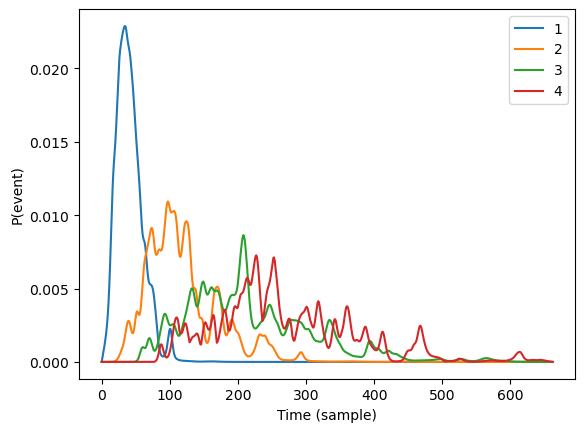

In [20]:
plt.plot(estimates.eventprobs.mean('trial_x_participant'), label=[1,2,3,4])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.legend();

And we can even look at a single trial:

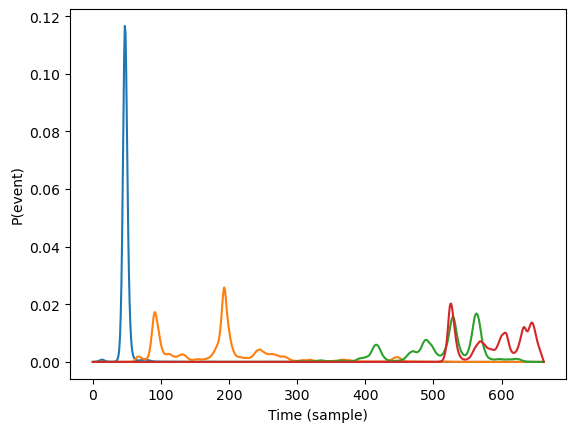

In [21]:
plt.plot(estimates.eventprobs.sel(trial_x_participant=('S0',0)), label=[1,2,3,4])
plt.ylabel('P(event)')
plt.xlabel('Time (sample)');

And in the case of simulation compare that to the actual generating moment:

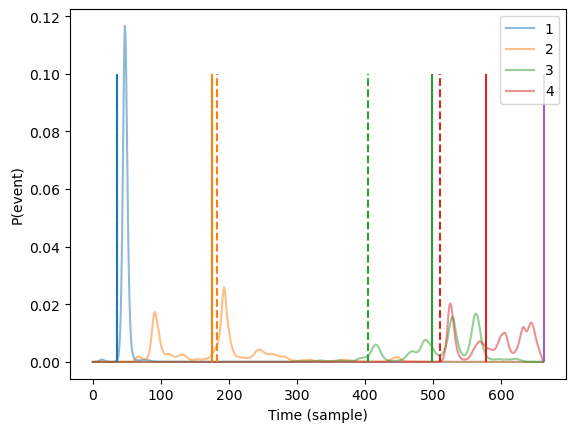

In [22]:
estimated_times = init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T
plt.plot(estimates.eventprobs.sel(trial_x_participant=('S0',0)), label=[1,2,3,4], alpha=.5)
plt.ylabel('P(event)')
plt.xlabel('Time (sample)')
plt.vlines(np.cumsum(sim_source_times[0,:]), 0,.1, color=colors, ls='--')
plt.vlines(np.cumsum(estimated_times.sel(trial_x_participant=('S0',0))), 0,.1, color=colors, ls='-')
plt.legend();

If we select for all trials the most likely sample to contain a transition we can take a look at the recovery of our simulated times on all trials:

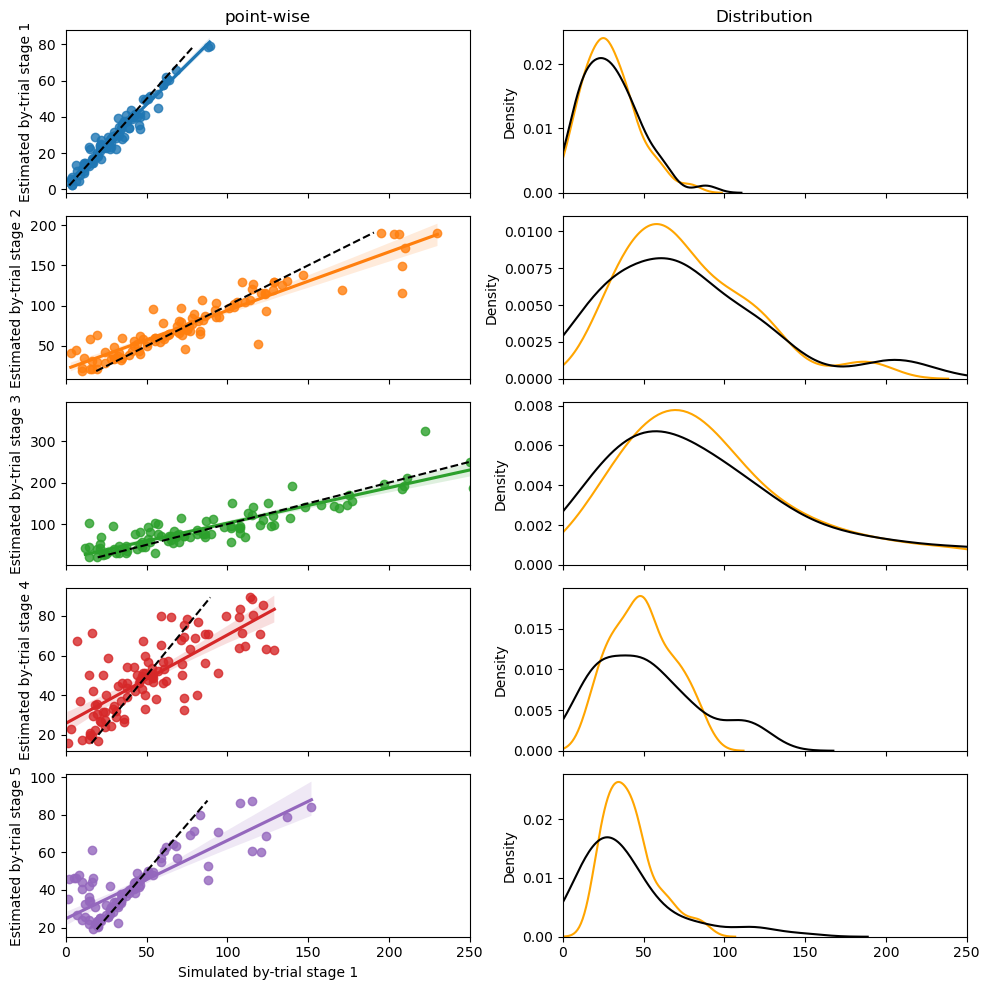

In [23]:
fig, ax = plt.subplots(n_stages,2, figsize=(10,2*n_stages), dpi=100, sharex=True)
i = 0
ax[0,0].set_title('point-wise')
ax[0,1].set_title('Distribution')
ax[-1,0].set_xlabel(f'Simulated by-trial stage {i+1}')

for event in estimated_times:
    sns.regplot(x=sim_source_times[:,i].T, y=event, ax=ax[i,0], color=colors[i])
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')
    ax[i,0].set_ylabel(f'Estimated by-trial stage {i+1}')
    sns.kdeplot(event, ax=ax[i,1], color='orange')
    sns.kdeplot(sim_source_times[:,i].T, ax=ax[i,1], color='k')
    i+= 1

plt.xlim(0,250)
plt.tight_layout();

# Exercise


Now based on the assumptions of an HMP model in terms of expected stage distribution and length of the event, and based on the implemented possibilities of stage distribution (see below) and event duration (in theory from 1 to +$\infty$ but in practice limited by your sampling frequency and length of your epochs), suggest an alternative HMP model and test the recovery of the original parameters (gamma with a shape of 2 and an event duration of 50ms)

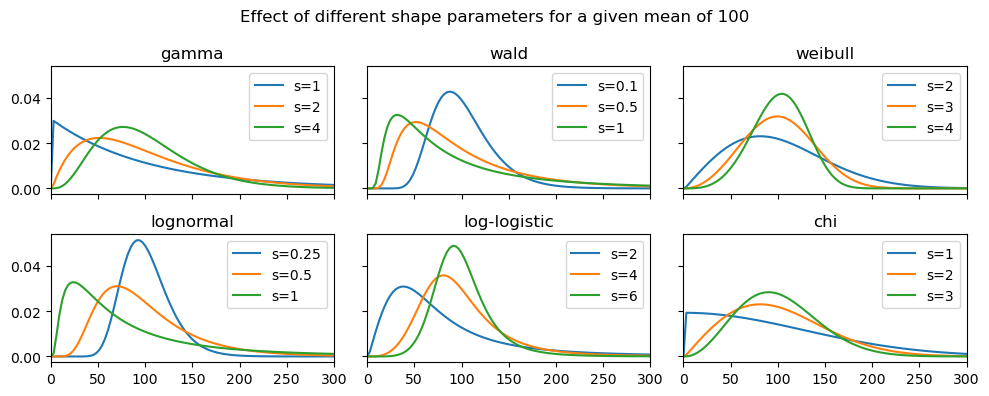

In [24]:
#Illustrating implemented distributions
#The supported families are the one displayed in the next list
#shape is a semi-continous parameter (0 to +infinity)

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(10,4))
plt.suptitle('Effect of different shape parameters for a given mean of 100')
distributions = [[['gamma',1],['gamma',2],['gamma',4]],
                 [['wald',.1],['wald',.5],['wald',1]],
                 [['weibull',2],['weibull',3],['weibull',4]],
                 [['lognormal',.25],['lognormal',.5],['lognormal',1]],
                 [['log-logistic',2],['log-logistic',4],['log-logistic',6]],
                 [['half-normal',1],['rayleigh',2],['maxwell-boltzmann',3]],]
i,j = 0,0
axes = [ax[0,0],ax[0,1],ax[0,2],ax[1,0], ax[1,1],ax[1,2]]
for family in distributions:
    for distribution in family:
        hmp.visu.plot_expected_distribution(distribution[0], 100, distribution[1], location=0, xmax=300, label=f's={distribution[1]}', ax=axes[j])
    axes[j].legend()
    axes[j].set_title(family[0][0])
    j += 1
    
plt.xlim(0,300)
axes[-1].set_title('chi')
plt.tight_layout();

Replace event_width or distribution or shape (or all three) in the HMP initialisation:

Estimating 4 events model with 1 starting point(s)
parameters estimated for 4 events model


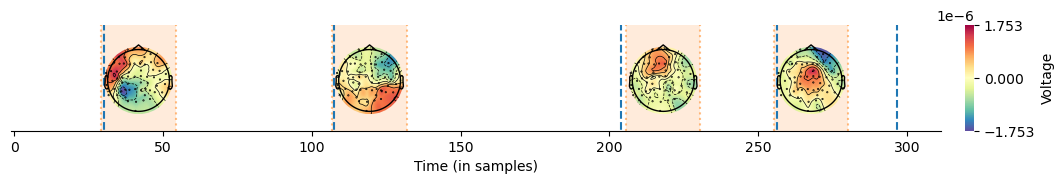

In [25]:
init = hmp.models.hmp(data=hmp_data, epoch_data=eeg_data, sfreq=eeg_data.sfreq,
                      event_width=50, distribution='gamma', shape=2)

estimates = init.fit_single(n_events)
hmp.visu.plot_topo_timecourse(eeg_data, estimates, positions, init, magnify=1, sensors=True, 
        times_to_display = np.mean(np.cumsum(sim_source_times,axis=1),axis=0))

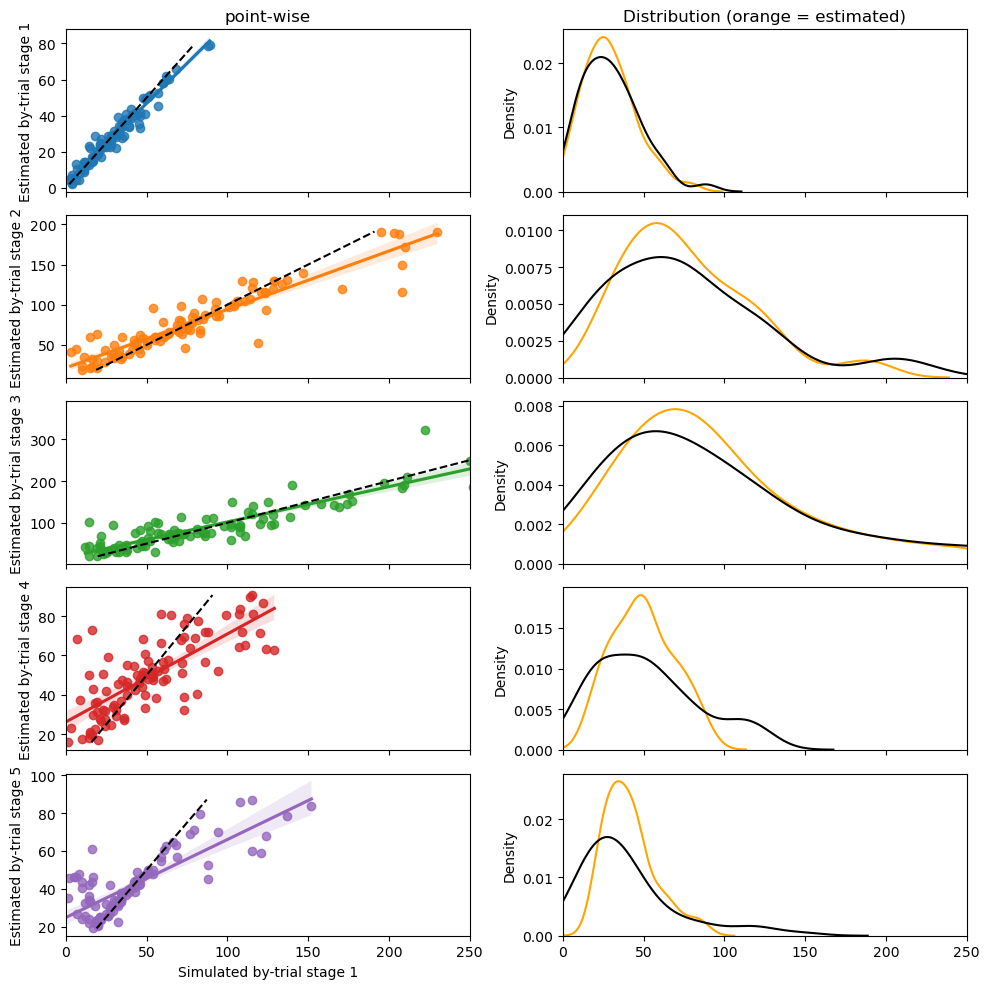

In [26]:
fig, ax = plt.subplots(n_stages,2, figsize=(10,2*n_stages), dpi=100, sharex=True)
i = 0
ax[0,0].set_title('point-wise')
ax[0,1].set_title('Distribution (orange = estimated)')
ax[-1,0].set_xlabel(f'Simulated by-trial stage {i+1}')

for event in init.compute_times(init, estimates, duration=True, mean=False, add_rt=True).T:
    sns.regplot(x=sim_source_times[:,i].T, y=event, ax=ax[i,0], color=colors[i])
    ax[i,0].plot([np.min(event), np.max(event)], [np.min(event), np.max(event)],'--', color='k')
    ax[i,0].set_ylabel(f'Estimated by-trial stage {i+1}')
    sns.kdeplot(event, ax=ax[i,1], color='orange')
    sns.kdeplot(sim_source_times[:,i].T, ax=ax[i,1], color='k')
    i+= 1

plt.xlim(0,250)
plt.tight_layout();